In [140]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import pandas as pd


from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [141]:
import pathlib
data_dir = pathlib.Path("./train/")
data_dir_val = pathlib.Path("./test/")

In [142]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

batch_size = 17 # Divisors of number 1156: 1, 2, 4, 17, 34, 68, 289, 578, 1156
img_height = 180
img_width = 180

1156


In [143]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    # seed=12,
)

Found 1156 files belonging to 9 classes.


In [144]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_val,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  # seed=24,
  )

Found 502 files belonging to 9 classes.


In [145]:
class_names = train_ds.class_names
print(class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1111).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# normalization_layer = layers.Rescaling(1./255)

# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# print(np.min(first_image), np.max(first_image))

['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'NabtatAli', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


In [146]:
num_classes = len(class_names)
epochs = 30
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, activation='relu',padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu',padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu',padding='same'),
    layers.MaxPooling2D(),
    # layers.Dropout(0.2,seed=48),
    layers.Flatten(),
    # layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_19 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 45, 45, 64)      

In [147]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  # shuffle=False
)

Epoch 1/30
68/68 [==============================] - 19s 253ms/step - loss: 2.1697 - accuracy: 0.2422 - val_loss: 1.5972 - val_accuracy: 0.4163
Epoch 2/30
68/68 [==============================] - 17s 247ms/step - loss: 1.1734 - accuracy: 0.5744 - val_loss: 0.8832 - val_accuracy: 0.6793
Epoch 3/30
68/68 [==============================] - 17s 248ms/step - loss: 0.6294 - accuracy: 0.8010 - val_loss: 0.6561 - val_accuracy: 0.7311
Epoch 4/30
68/68 [==============================] - 17s 256ms/step - loss: 0.4628 - accuracy: 0.8469 - val_loss: 0.4536 - val_accuracy: 0.8546
Epoch 5/30
68/68 [==============================] - 17s 246ms/step - loss: 0.3889 - accuracy: 0.8798 - val_loss: 0.3357 - val_accuracy: 0.8765
Epoch 6/30
68/68 [==============================] - 17s 246ms/step - loss: 0.3333 - accuracy: 0.8849 - val_loss: 0.3985 - val_accuracy: 0.8466
Epoch 7/30
68/68 [==============================] - 17s 247ms/step - loss: 0.2521 - accuracy: 0.9178 - val_loss: 0.5180 - val_accuracy: 0.8247

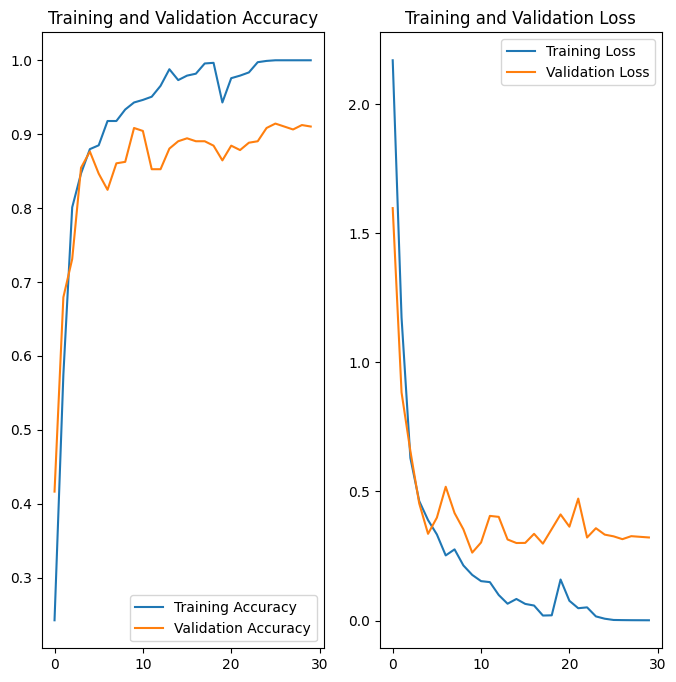

In [148]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [149]:
img = list(data_dir_val.glob('Medjool/*'))
img = PIL.Image.open(str(img[21])).resize((180, 180))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 81ms/step
This image most likely belongs to Medjool with a 100.00 percent confidence.


In [150]:
predicted = []
true_labels = []
dirs = list(data_dir_val.glob('*'))

for d in range(len(dirs)):
    dir = dirs[d]
    predicted.append([])

    for image in dir.glob('*/'):
        image = PIL.Image.open(image).resize((180, 180))
        img_array = tf.keras.utils.img_to_array(image)
        img_array = tf.expand_dims(img_array, 0)

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        result = np.argmax(score)
        predicted[d].append(result)
        true_labels.append(d)

1/1 [==============================] - 0s 29ms/step


In [151]:
confusion_matrix = []
for l in range(len(predicted)):
    confusion_matrix.append([])
    for i in range(len(predicted)):
        confusion_matrix[l].append(predicted[l].count(i))

In [152]:
flat_predicted = [item for sublist in predicted for item in sublist]

print("Accuracy:", accuracy_score(true_labels, flat_predicted))

Accuracy: 0.9063745019920318


In [153]:
print(classification_report(true_labels, flat_predicted))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        53
           1       0.98      0.81      0.88        57
           2       0.93      0.93      0.93        41
           3       0.80      0.90      0.85        70
           4       0.85      0.94      0.89        54
           5       0.93      0.89      0.91        44
           6       0.98      0.92      0.95        52
           7       0.93      0.93      0.93        80
           8       0.88      0.84      0.86        51

    accuracy                           0.91       502
   macro avg       0.91      0.91      0.91       502
weighted avg       0.91      0.91      0.91       502



<AxesSubplot: >

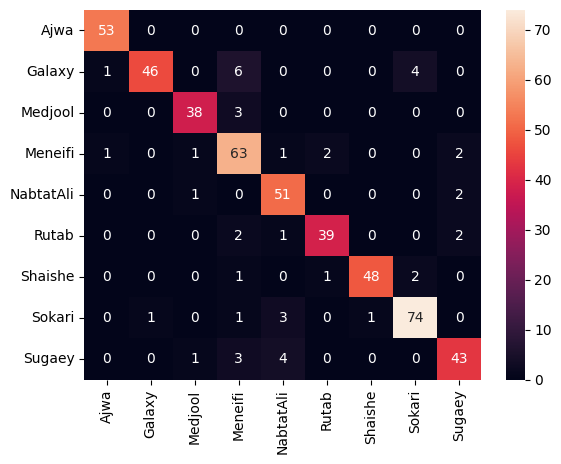

In [154]:
cm_df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
sns.heatmap(cm_df, annot=True)